## Import Libraries & Load Data

In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from facenet_pytorch import InceptionResnetV1
from IPython.display import clear_output
import torchvision.models as models
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from torch import nn
import numpy as np
import torch, os, random, time

In [2]:
projectPath = os.getcwd()

## Create the Neural Network

In [3]:
MinAge, MaxAge = 1, 90
MinGender, MaxGender = 0, 1
Classes = 9
Groups = ['00-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']

runOn = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
"""
MyModel = InceptionResnetV1(pretrained='vggface2', classify=True)

MyModel.logits = nn.Linear(512, Classes+2, bias=True)
MyModel = nn.Sequential(MyModel, nn.Dropout(0.5))
MyModel = nn.Sequential(MyModel, nn.Sigmoid())

runOn = "cuda:0" if torch.cuda.is_available() else "cpu"
MyModel.to(runOn);
"""

In [ ]:
MyModel = models.resnet18(pretrained=True)

MyModel.fc = nn.Linear(512, Classes+2)
MyModel = nn.Sequential(MyModel, nn.Sigmoid())

FaceClassifier.to(runOn);

## Create UTK Dataset

In [7]:
def checkImage(imgName):
    if '/' in imgName: imgName = imgName.split('/')[-1]
    metaData = imgName.split('_')
    Age, Gender = int(metaData[0]), int(metaData[1])
    validGender = (Gender >= MinGender and Gender <= MaxGender)
    validAge = (Age >= MinAge and Age <= MaxAge)
    
    return validAge and validGender

class AGE_GENDER(torch.utils.data.Dataset):
    def __init__(self, dataPath, fileList, transform=None):
        self.dataPath = dataPath
        self.fileList = fileList
        self.transform = transform
        
        for imgName in self.fileList:
            if not checkImage(imgName):
                self.fileList.remove(imgName)
    
    def GetGroup(self, age):
        """
        00-10 Group 1
        11-20 Group 2
        21-30 Group 3
        31-40 Group 4
        41-50 Group 5
        51-60 Group 6
        61-70 Group 7
        71-80 Group 8
        81-90 Group 9
        """

        if 0 <= age and age <= 10: return 1
        if 11 <= age and age <= 20: return 2
        if 21 <= age and age <= 30: return 3
        if 31 <= age and age <= 40: return 4
        if 41 <= age and age <= 50: return 5
        if 51 <= age and age <= 60: return 6
        if 61 <= age and age <= 70: return 7
        if 71 <= age and age <= 80: return 8
        if 81 <= age and age <= 90: return 9
        else: raise ValueError(f"Age {age} does not fit inside any group.")
    
    def __getitem__(self, i):
        imgName = self.fileList[i]
        fileName = self.dataPath + imgName
        IMG = Image.open(fileName)
        x = IMG.convert('RGB')
        if self.transform: x = self.transform(x)
        
        if '/' in imgName: imgName = imgName.split('/')[-1]
        metaData = imgName.split('_')
        Age, Gender = int(metaData[0]), int(metaData[1])
        
        ageTensor, genderTensor = torch.zeros(Classes), torch.zeros(2)
        
        ageTensor[self.GetGroup(Age)-1] = 1
        genderTensor[Gender] = 1
        y = torch.cat([ageTensor, genderTensor], dim=0) # Merge tensors.

        return x, y
    
    def extractInfo(self, i):
        imgName = self.fileList[i]
        
        if '/' in imgName: imgName = imgName.split('/')[-1]

        metaData = imgName.split('_')
        Age, Gender = int(metaData[0]), int(metaData[1])

        return Age, Gender
    
    def testItem(self, i):
        return self[i], self.fileList[i]

    def __len__(self):
        return len(self.fileList)

In [8]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Resize((200, 200)),
                                transforms.RandomRotation(10)])

def displayInfo(DATASET, name='', nBins=MaxAge):
    Ages, Genders = [], []
    for i in range(len(DATASET)):
        Age, Gender = DATASET.extractInfo(i)
        Ages.append(Age)
        Genders.append(Gender)

    plt.title(f'{name} Ages Distribution')
    plt.xlabel('Person Age')
    plt.ylabel('Number of Images')
    plt.hist(Ages, nBins)
    plt.show()

    plt.title(f'{name} Gender Distribution')
    plt.xlabel('Person Gender')
    plt.ylabel('Number of Images')
    Genders = [Genders.count(0), Genders.count(1)]
    plt.bar([0, 1], Genders)
    plt.show()

def extractFileInfo(fileName):
    Age, Gender = fileName.split('_')[:2]
    return int(Age), int(Gender)

In [9]:
DATA_PATH = projectPath + '/UTK' + '/Images/'
fileList = os.listdir(DATA_PATH)

for imgName in fileList:
    if not checkImage(imgName): fileList.remove(imgName)

In [10]:
TRAIN = 80
VALIDATION = 10
TEST = 10

trainPart = int(len(fileList) * TRAIN/100)
validationPart = int(len(fileList) * VALIDATION/100)
testPart = int(len(fileList) * TEST/100)
total = trainPart + validationPart + testPart
trainPart += (len(fileList) - total)

if (trainPart + validationPart + testPart) == len(fileList): print("Correct Partition")

Correct Partition


In [13]:
TRAIN_DATASET = AGE_GENDER(DATA_PATH, fileList[0:trainPart], transform)
VALIDATION_DATASET = AGE_GENDER(DATA_PATH, fileList[trainPart:trainPart+validationPart], transform)
TEST_DATASET = AGE_GENDER(DATA_PATH, fileList[trainPart+validationPart:], transform)

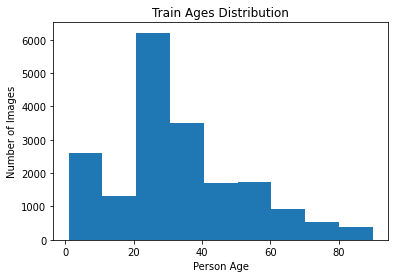

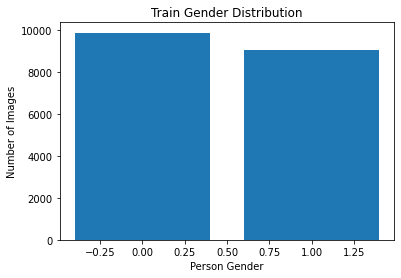

In [16]:
displayInfo(TRAIN_DATASET, 'Train', Classes)

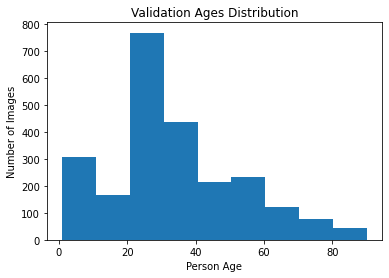

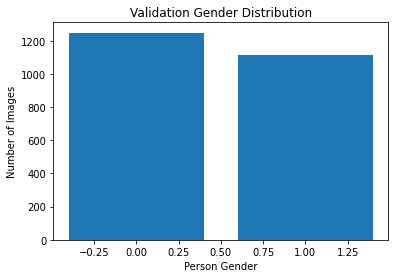

In [11]:
displayInfo(VALIDATION_DATASET, 'Validation', Classes)

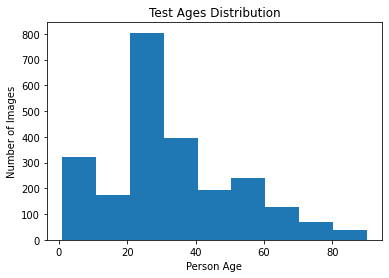

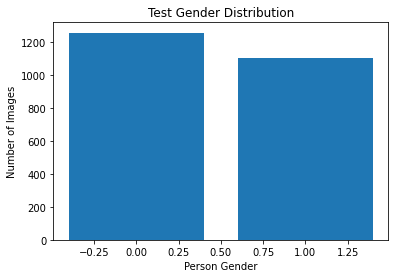

In [12]:
displayInfo(TEST_DATASET, 'Test', Classes)

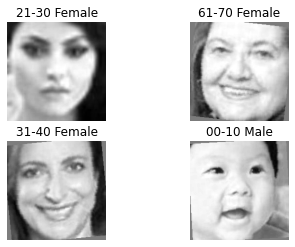

In [18]:
Rows, Columns = 2, 2
def GetRandom(): return np.random.randint(0, len(TRAIN_DATASET)-1)
randomIndex = [GetRandom() for _ in range(Rows*Columns)]

for i in range(Rows*Columns):
    x, y = TRAIN_DATASET[randomIndex[i]]
    Age = int(np.argmax(y[:Classes]))
    Gender = 'Male' if int(np.argmax(y[Classes:])) == 0 else 'Female'

    plt.subplot(Rows, Columns, i+1)
    plt.title(f'{Groups[Age]} {Gender}')
    plt.imshow(x.numpy()[0], cmap='gray')
    plt.axis('off')
plt.show()

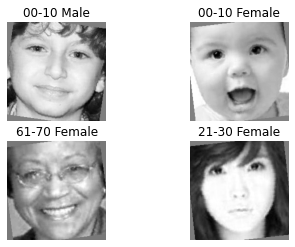

In [19]:
Rows, Columns = 2, 2
def GetRandom(): return np.random.randint(0, len(VALIDATION_DATASET)-1)
randomIndex = [GetRandom() for _ in range(Rows*Columns)]

for i in range(Rows*Columns):
    x, y = VALIDATION_DATASET[randomIndex[i]]
    Age = int(np.argmax(y[:Classes]))
    Gender = 'Male' if int(np.argmax(y[Classes:])) == 0 else 'Female'

    plt.subplot(Rows, Columns, i+1)
    plt.title(f'{Groups[Age]} {Gender}')
    plt.imshow(x.numpy()[0], cmap='gray')
    plt.axis('off')
plt.show()

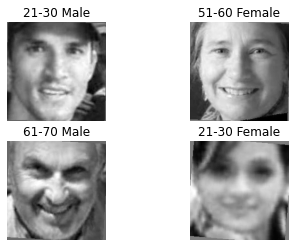

In [20]:
Rows, Columns = 2, 2
def GetRandom(): return np.random.randint(0, len(TEST_DATASET)-1)
randomIndex = [GetRandom() for _ in range(Rows*Columns)]

for i in range(Rows*Columns):
    x, y = TEST_DATASET[randomIndex[i]]
    Age = int(np.argmax(y[:Classes]))
    Gender = 'Male' if int(np.argmax(y[Classes:])) == 0 else 'Female'

    plt.subplot(Rows, Columns, i+1)
    plt.title(f'{Groups[Age]} {Gender}')
    plt.imshow(x.numpy()[0], cmap='gray')
    plt.axis('off')
plt.show()

## Train Model

In [20]:
def train(MyModel, DATA, LossFunctions, Optimizer, Epochs, onDevice, batchSize):
    MyModel.to(onDevice)
    runID = time.time()
    TRAIN_DATA, VALIDATION_DATA = DATA['TRAIN'], DATA['VALIDATION']
    LossFunctionAge = LossFunctions['Age']
    LossFunctionGender = LossFunctions['Gender']
    lossHistory, bestLoss = {'TRAIN': [], 'VALIDATION': []}, -1
    validationLoss = -1
    
    trainLoader = torch.utils.data.DataLoader(dataset=TRAIN_DATA, 
                                              batch_size=batchSize,
                                              shuffle=True,
                                              num_workers=2, 
                                              pin_memory=True)
    
    validationLoader = torch.utils.data.DataLoader(dataset=VALIDATION_DATA,
                                                  batch_size=batchSize,
                                                  shuffle=True,
                                                  num_workers=2, 
                                                  pin_memory=True)
    
    schedulerLR = torch.optim.lr_scheduler.ReduceLROnPlateau(Optimizer, 'min', patience=2, verbose=True)
    totalSteps = len(trainLoader)
    MyModel.train()
    try:
        for Epoch in range(Epochs):
            for i, (x, y) in enumerate(trainLoader):
                x = x.to(onDevice)
                y = y.to(onDevice)

                y_ = MyModel(x)
                Optimizer.zero_grad()
                
                NetworkAge = y_[:,:Classes] # Network prediction on age, use MSE Loss.
                DatasetAge = y[:,:Classes] # Dataset age tensor, [0, 0, ...., 1, 0, 0 ...0]
                
                NetworkGender = y_[:,Classes:] # Network prediction on gender, use BCE Loss.
                DatasetGender = y[:,Classes:] # Dataset gender tensor [0, 1] or [1, 0]
                
                ageLoss = LossFunctionAge(NetworkAge, DatasetAge)
                genderLoss = LossFunctionGender(NetworkGender, DatasetGender)
                
                loss = ageLoss + genderLoss
                loss.backward()

                Optimizer.step()

                if (i+1)%5 == 0:
                    clear_output(wait=True)
                    print ('Epoch [{}/{}] Step [{}/{}] Loss: {:.4f}' 
                           .format(Epoch+1, Epochs, i+1, totalSteps, loss.item()), end=' ')
                    print(f'Last Validation: {round(validationLoss,4)} Best Validation: {round(bestLoss,4)}')

                lossHistory['TRAIN'].append(loss.item())

            validationLoss = 0
            for i, (x, y) in enumerate(validationLoader):
                x = x.to(onDevice)
                y = y.to(onDevice)

                y_ = MyModel(x)
                Optimizer.zero_grad()
                
                NetworkAge = y_[:,:Classes] # Network prediction on age, use MSE Loss.
                DatasetAge = y[:,:Classes] # Dataset age tensor, [0, 0, ...., 1, 0, 0 ...0]
                
                NetworkGender = y_[:,Classes:] # Network prediction on gender, use BCE Loss.
                DatasetGender = y[:,Classes:] # Dataset gender tensor [0, 1] or [1, 0]
                
                ageLoss = LossFunctionAge(NetworkAge, DatasetAge)
                genderLoss = LossFunctionGender(NetworkGender, DatasetGender)

                loss = ageLoss + genderLoss
                loss.backward()

                Optimizer.step()

                lossHistory['VALIDATION'].append(loss.item())
                validationLoss += loss.item()
            validationLoss = validationLoss / (i+1)
            schedulerLR.step(validationLoss)

            if validationLoss < bestLoss or bestLoss == -1:
                modelPath = projectPath + '/Models/' + f'Best [{runID}].pt'
                torch.save(MyModel.state_dict(), modelPath)
                bestLoss = validationLoss

            dateTime = (str(datetime.now())).split('.')[0].replace(' ', '_')
            modelName = dateTime + f"_Epoch={Epoch+1}"
            modelPath = projectPath + '/Models/' + modelName + '.pt'
            torch.save(MyModel.state_dict(), modelPath)
    except KeyboardInterrupt:
        return lossHistory
    return lossHistory

def test(MyModel, DATASET, runOn, batchSize):
    MyModel.to(runOn)
    MyModel.eval()
    totalCases = len(DATASET)
    AgeDf, GenderDf = [], 0
    testLoader = torch.utils.data.DataLoader(dataset=DATASET,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=2, 
                                                  pin_memory=True)
    totalSteps = len(testLoader)
    
    for i, (x, y) in enumerate(testLoader):
        x = x.to(runOn)
        y = y.to(runOn)
            
        RealAge = int(torch.argmax(y[0][:Classes]))
        RealGender = int(torch.argmax(y[0][Classes:]))

        y_ = MyModel(x)
        
        PredAge = int(torch.argmax(y_[0][:Classes]))
        PredGender = int(torch.argmax(y_[0][Classes:]))
        
        AgeDf.append(abs(RealAge - PredAge))
        GenderDf += abs(RealGender - PredGender)
        
        if (i+1)%100 == 0:
            clear_output(wait=True)
            tempAge = sum(AgeDf)/len(AgeDf)
            tempGender = ((totalCases-GenderDf)/totalCases)*100
            print(f"{i+1}/{totalSteps} \t Age: {round(tempAge, 3)} \t Gender: {round(tempGender, 3)}%")
    
    # Mean age difference and non-failed gender cases.
    return sum(AgeDf)/len(AgeDf), ((totalCases-GenderDf)/totalCases)*100

In [ ]:
LossFunctions = {'Age': nn.MSELoss(), 'Gender': nn.BCELoss()}

Optimizer = torch.optim.Adam(MyModel.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-6)

Epochs = 25
BatchSize = 64

In [ ]:
DATA = {'TRAIN':TRAIN_DATASET, 'VALIDATION':VALIDATION_DATASET}
lossHistory = train(MyModel, DATA, LossFunctions, Optimizer, Epochs, runOn, BatchSize)

In [ ]:
stepsAtEpoch1 = (len(DATA['TRAIN']) // BatchSize) + 1
stepsAtEpoch2 = (len(DATA['VALIDATION']) // BatchSize) + 1

In [ ]:
plt.title('Training Loss')
plt.plot(lossHistory['TRAIN'], label='Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
trainLoss = []
for i in range(Epochs):
    x = lossHistory['TRAIN'][i*stepsAtEpoch1]
    trainLoss.append(x)
    
validationLoss = []
for i in range(Epochs):
    x = lossHistory['VALIDATION'][i*stepsAtEpoch2]
    validationLoss.append(x)
    
plt.plot(trainLoss, label='Training')
plt.plot(validationLoss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
AgeError, GenderAccuray = test(MyModel, TEST_DATASET, runOn, 32)

In [28]:
def displayPredictions(MyModel, DATASET, runOn, Rows, Columns):
    MyModel.to(runOn)
    MyModel.eval()
    for i in range(Rows*Columns):
        x, y = DATASET[np.random.randint(0, len(DATASET)-1)]
        xNet = x.unsqueeze(0).to(runOn)
        y = y.to(runOn)

        Age = int(torch.argmax(y[:Classes]))
        Gender = 'Male' if int(torch.argmax(y[Classes:])) == 0 else 'Female'
        
        y = MyModel(xNet)[0]

        PredAge = int(torch.argmax(y[:Classes]))
        PredGender = 'Male' if int(torch.argmax(y[Classes:])) == 0 else 'Female'
        
        plt.subplot(Rows, Columns, i+1)
        plt.title(f'Real: {Groups[Age]} {Gender} | Prediction: {Groups[PredAge]} {PredGender}')
        plt.imshow(x[0], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)

## ResNet-18 

In [21]:
MyModel = models.resnet18(pretrained=True)

MyModel.fc = nn.Linear(512, Classes+2)
MyModel = nn.Sequential(MyModel, nn.Sigmoid())

runOn = "cuda:0" if torch.cuda.is_available() else "cpu"

MyModel.to(runOn);

In [22]:
LossFunctions = {'Age': nn.MSELoss(), 'Gender': nn.BCELoss()}

OptimizerSGD = torch.optim.SGD(MyModel.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)
OptimizerADAM = torch.optim.Adam(MyModel.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-6)

Epochs = 25
BatchSize = 64

In [23]:
DATA = {'TRAIN':TRAIN_DATASET, 'VALIDATION':VALIDATION_DATASET}
lossHistory = train(MyModel, DATA, LossFunctions, OptimizerADAM, Epochs, runOn, BatchSize)

Epoch [25/25] Step [295/296] Loss: 0.0891 Last Validation: 0.076 Best Validation: 0.076


In [24]:
stepsAtEpoch1 = (len(DATA['TRAIN']) // BatchSize) + 1
stepsAtEpoch2 = (len(DATA['VALIDATION']) // BatchSize) + 1

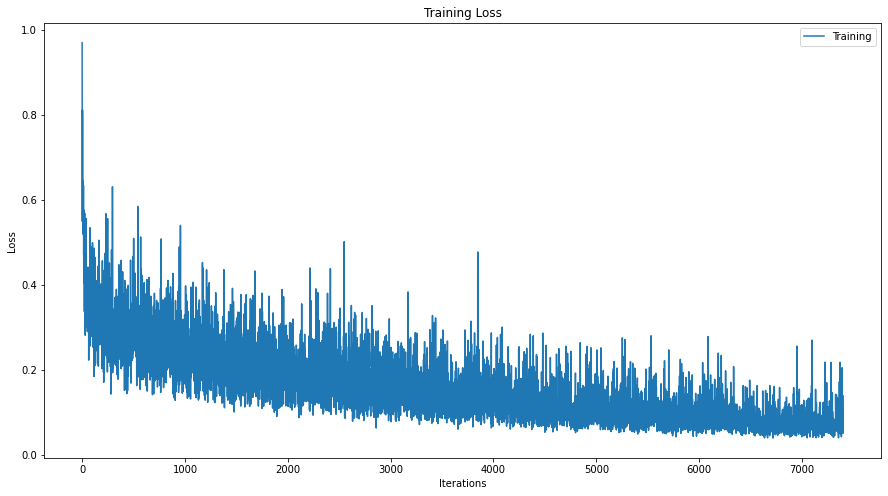

In [38]:
plt.figure(figsize=(15, 8))
plt.title('Training Loss')
plt.plot(lossHistory['TRAIN'], label='Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

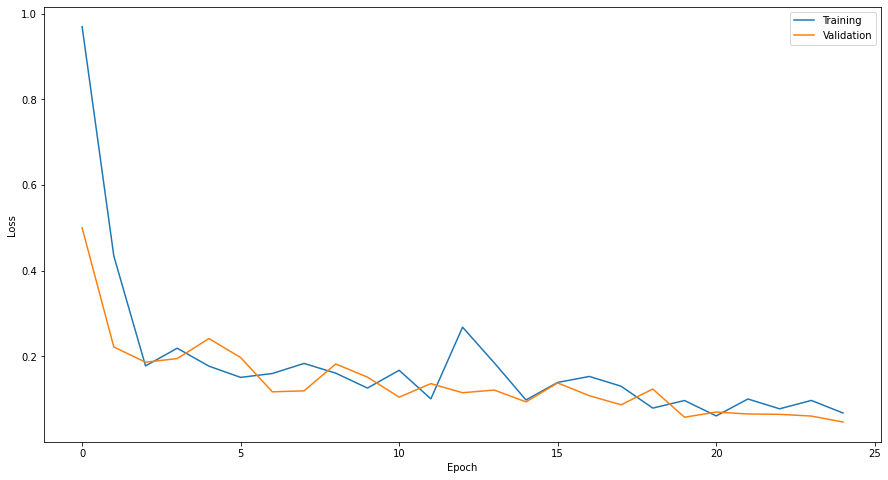

In [39]:
trainLoss = []
for i in range(Epochs):
    x = lossHistory['TRAIN'][i*stepsAtEpoch1]
    trainLoss.append(x)
    
validationLoss = []
for i in range(Epochs):
    x = lossHistory['VALIDATION'][i*stepsAtEpoch2]
    validationLoss.append(x)

plt.figure(figsize=(15, 8))
plt.plot(trainLoss, label='Training')
plt.plot(validationLoss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
AgeError, GenderAccuray = test(MyModel, TEST_DATASET, runOn, 32)

2300/2362 	 Age: 0.6 	 Gender: 93.48%


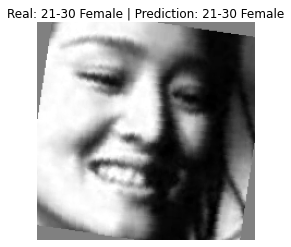

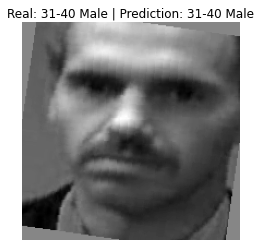

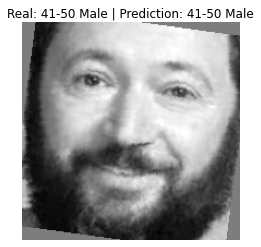

In [30]:
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)
displayPredictions(MyModel, TEST_DATASET, runOn, 1, 1)